In [50]:
from notebooks.__init__ import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load a config

In [51]:
with initialize_config_dir(config_dir='/home/konstantin/personal/Summertime/config', version_base='1.1'):
    cfg = compose(overrides=[
        "+train/dataset@predict.dataset=megadepth",
        "+train/criterion=setup/boness_st",
        "+method/detector=boness_st/default",
        f'+method.detector.checkpoint_url="file:///home/konstantin/personal/Summertime/weights/reference_model_epoch=15-avg_mAA=0.7263.ckpt"',
        "train.criterion.homography_distribution.beta=2.0"
    ])

    print(OmegaConf.to_yaml(cfg))

predict:
  dataset:
    root_path: /mnt/sda/datasets/MegaDepth
    csv_rel_path: train_disk.csv
    transforms:
      random_crop:
        width: 560
        height: 560
    loader:
      batch_size: 6
      num_samples: 23100
      shuffle: true
      num_workers: 4
train:
  criterion:
    patch_detector:
      base_detector:
        name: shi_tomasi
        sobel_size: 3
        window_size: 3
        window_cov: 2
        nms_size: 5
        localize: true
      unreliable_measurement_type: 3
    homography_distribution:
      beta: 2.0
      sampling_strategy: 1
    sample_detector:
      salient_thresh: 0.005
      noise_thresh: 0.0001
      base_detector:
        name: shi_tomasi
        sobel_size: 3
        window_size: 3
        window_cov: 2
        nms_size: 5
        localize: true
        score_thresh: 0.0
    beta_eme:
      bound: 1
      use_decomposition: true
    'n': 1024
    m: 100
method:
  detector:
    name: boness_st
    model:
      input_channels: 3
      down

# Instantiate a dataset and load an image

In [52]:
data_module = DataModule(predict_dataset_cfg=cfg.predict.dataset)
data_module.setup(stage='predict')


In [53]:

dataloader = data_module.predict_dataloader()

batch = next(iter(dataloader))

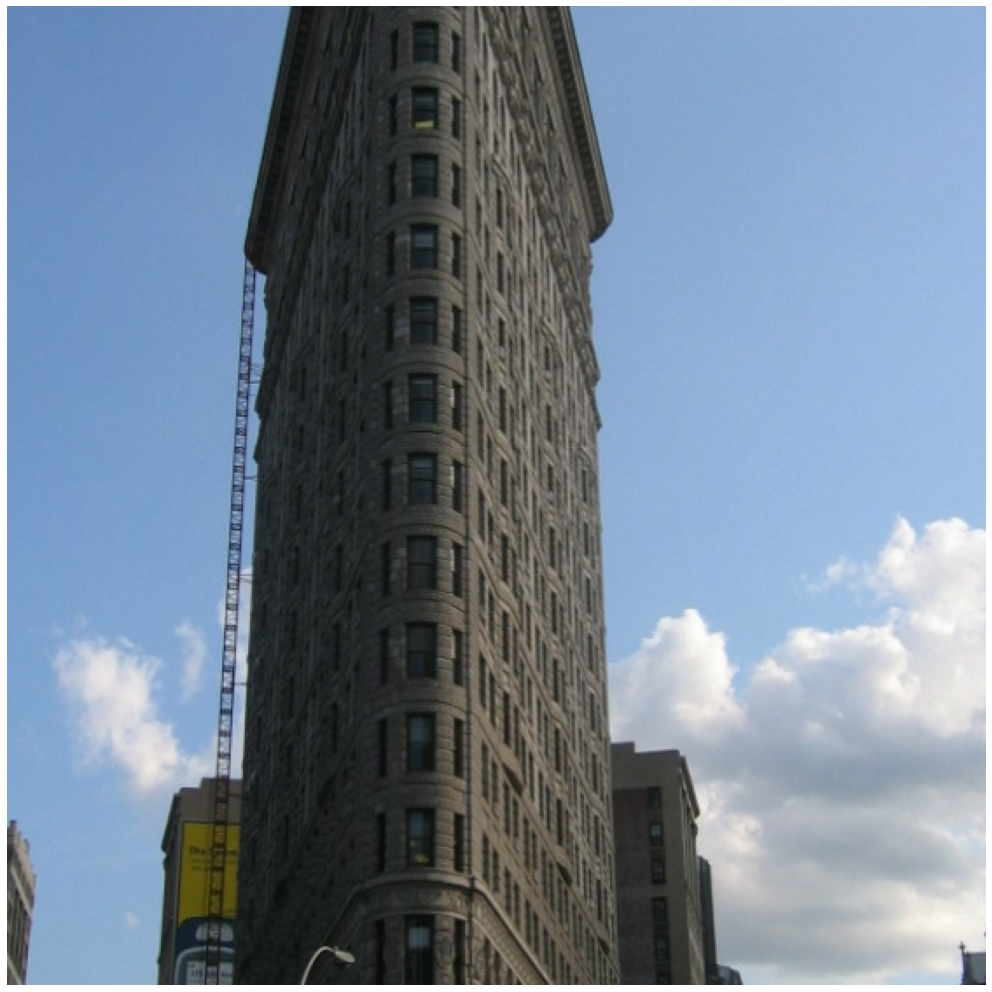

In [54]:
plot_images(batch['image'][0])

# Instantiate BoNeSS-ST

In [55]:
boness_st = instantiate_method(cfg.method.detector)

Loaded checkpoint 8eebf202947140e28ac1bace3ab04d5e for boness_st


# Prepare ground truth for training

## Instantiate classes for ground truth generation

In [56]:
patch_detector = PatchDetector(instantiate_base_detector(cfg.train.criterion.patch_detector.base_detector),
                               cfg.train.criterion.patch_detector.unreliable_measurement_type)

In [57]:
synth_h_dist = SyntheticHomographyDistribution(cfg.train.criterion.homography_distribution.beta,
                                               patch_detector.patch_size,
                                               cfg.train.criterion.homography_distribution.sampling_strategy)

In [58]:
sample_detector = NeSSDetector(boness_st.neur_beta_eme_model, 
                               instantiate_base_detector(cfg.train.criterion.sample_detector.base_detector))

## Get sample keypoints

In [59]:
kp_samples = sample_detector.get_keypoint_samples(batch['image'], batch['grayscale_image'], 
                                                  cfg.train.criterion.n,
                                                  synth_h_dist.border_size,
                                                  cfg.train.criterion.sample_detector.salient_thresh,
                                                  cfg.train.criterion.sample_detector.noise_thresh)

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


### Keypoint samples visualization

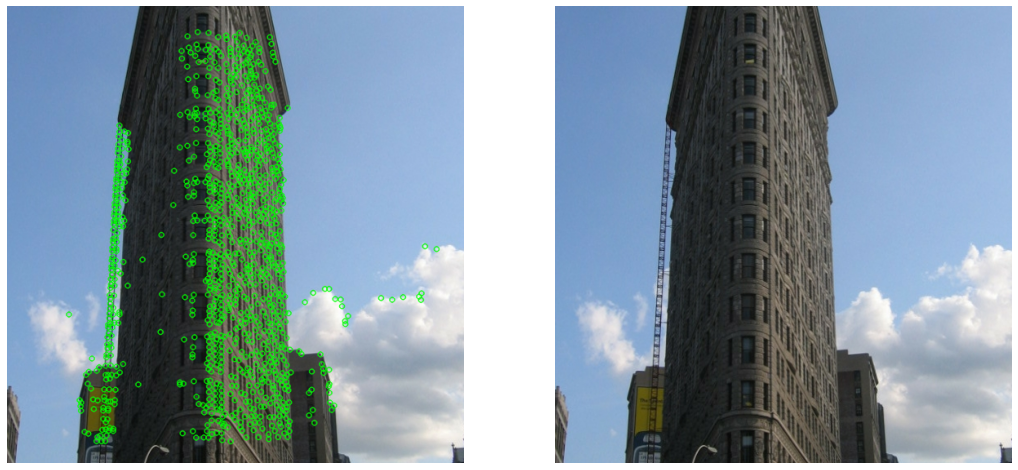

In [60]:
plot_keypoints([batch['image'][0], batch['image'][0]], 
               [kp_samples.kp[0], kp_samples.kp[0]], 
               [kp_samples.cand_kp_mask[0], kp_samples.cand_kp_noise_mask[0]],
               nrows=1, ncols=2)


## Generate keypoint projections

In [61]:
h = synth_h_dist.sample(cfg.train.criterion.m, torch.device('cpu'))

In [62]:
w_patch_gen = WarpedPatchGenerator(h, synth_h_dist.patch_scaled_size, torch.device('cpu'))

kp_proj_gen = w_patch_gen.get_keypoint_projection_generator(batch['grayscale_image'], kp_samples.kp, patch_detector.patch_size)

kp_proj = kp_proj_gen.generate_keypoint_projections(patch_detector)

### Visualize warped patches

In [63]:
w_vis_patch_painter = WarpedVisualizationPatchPainter(
    w_patch_gen.generate_warp_visualization_patches(
        batch['image'], 
        kp_samples.kp, 
        synth_h_dist.patch_scaled_size
        )
    )

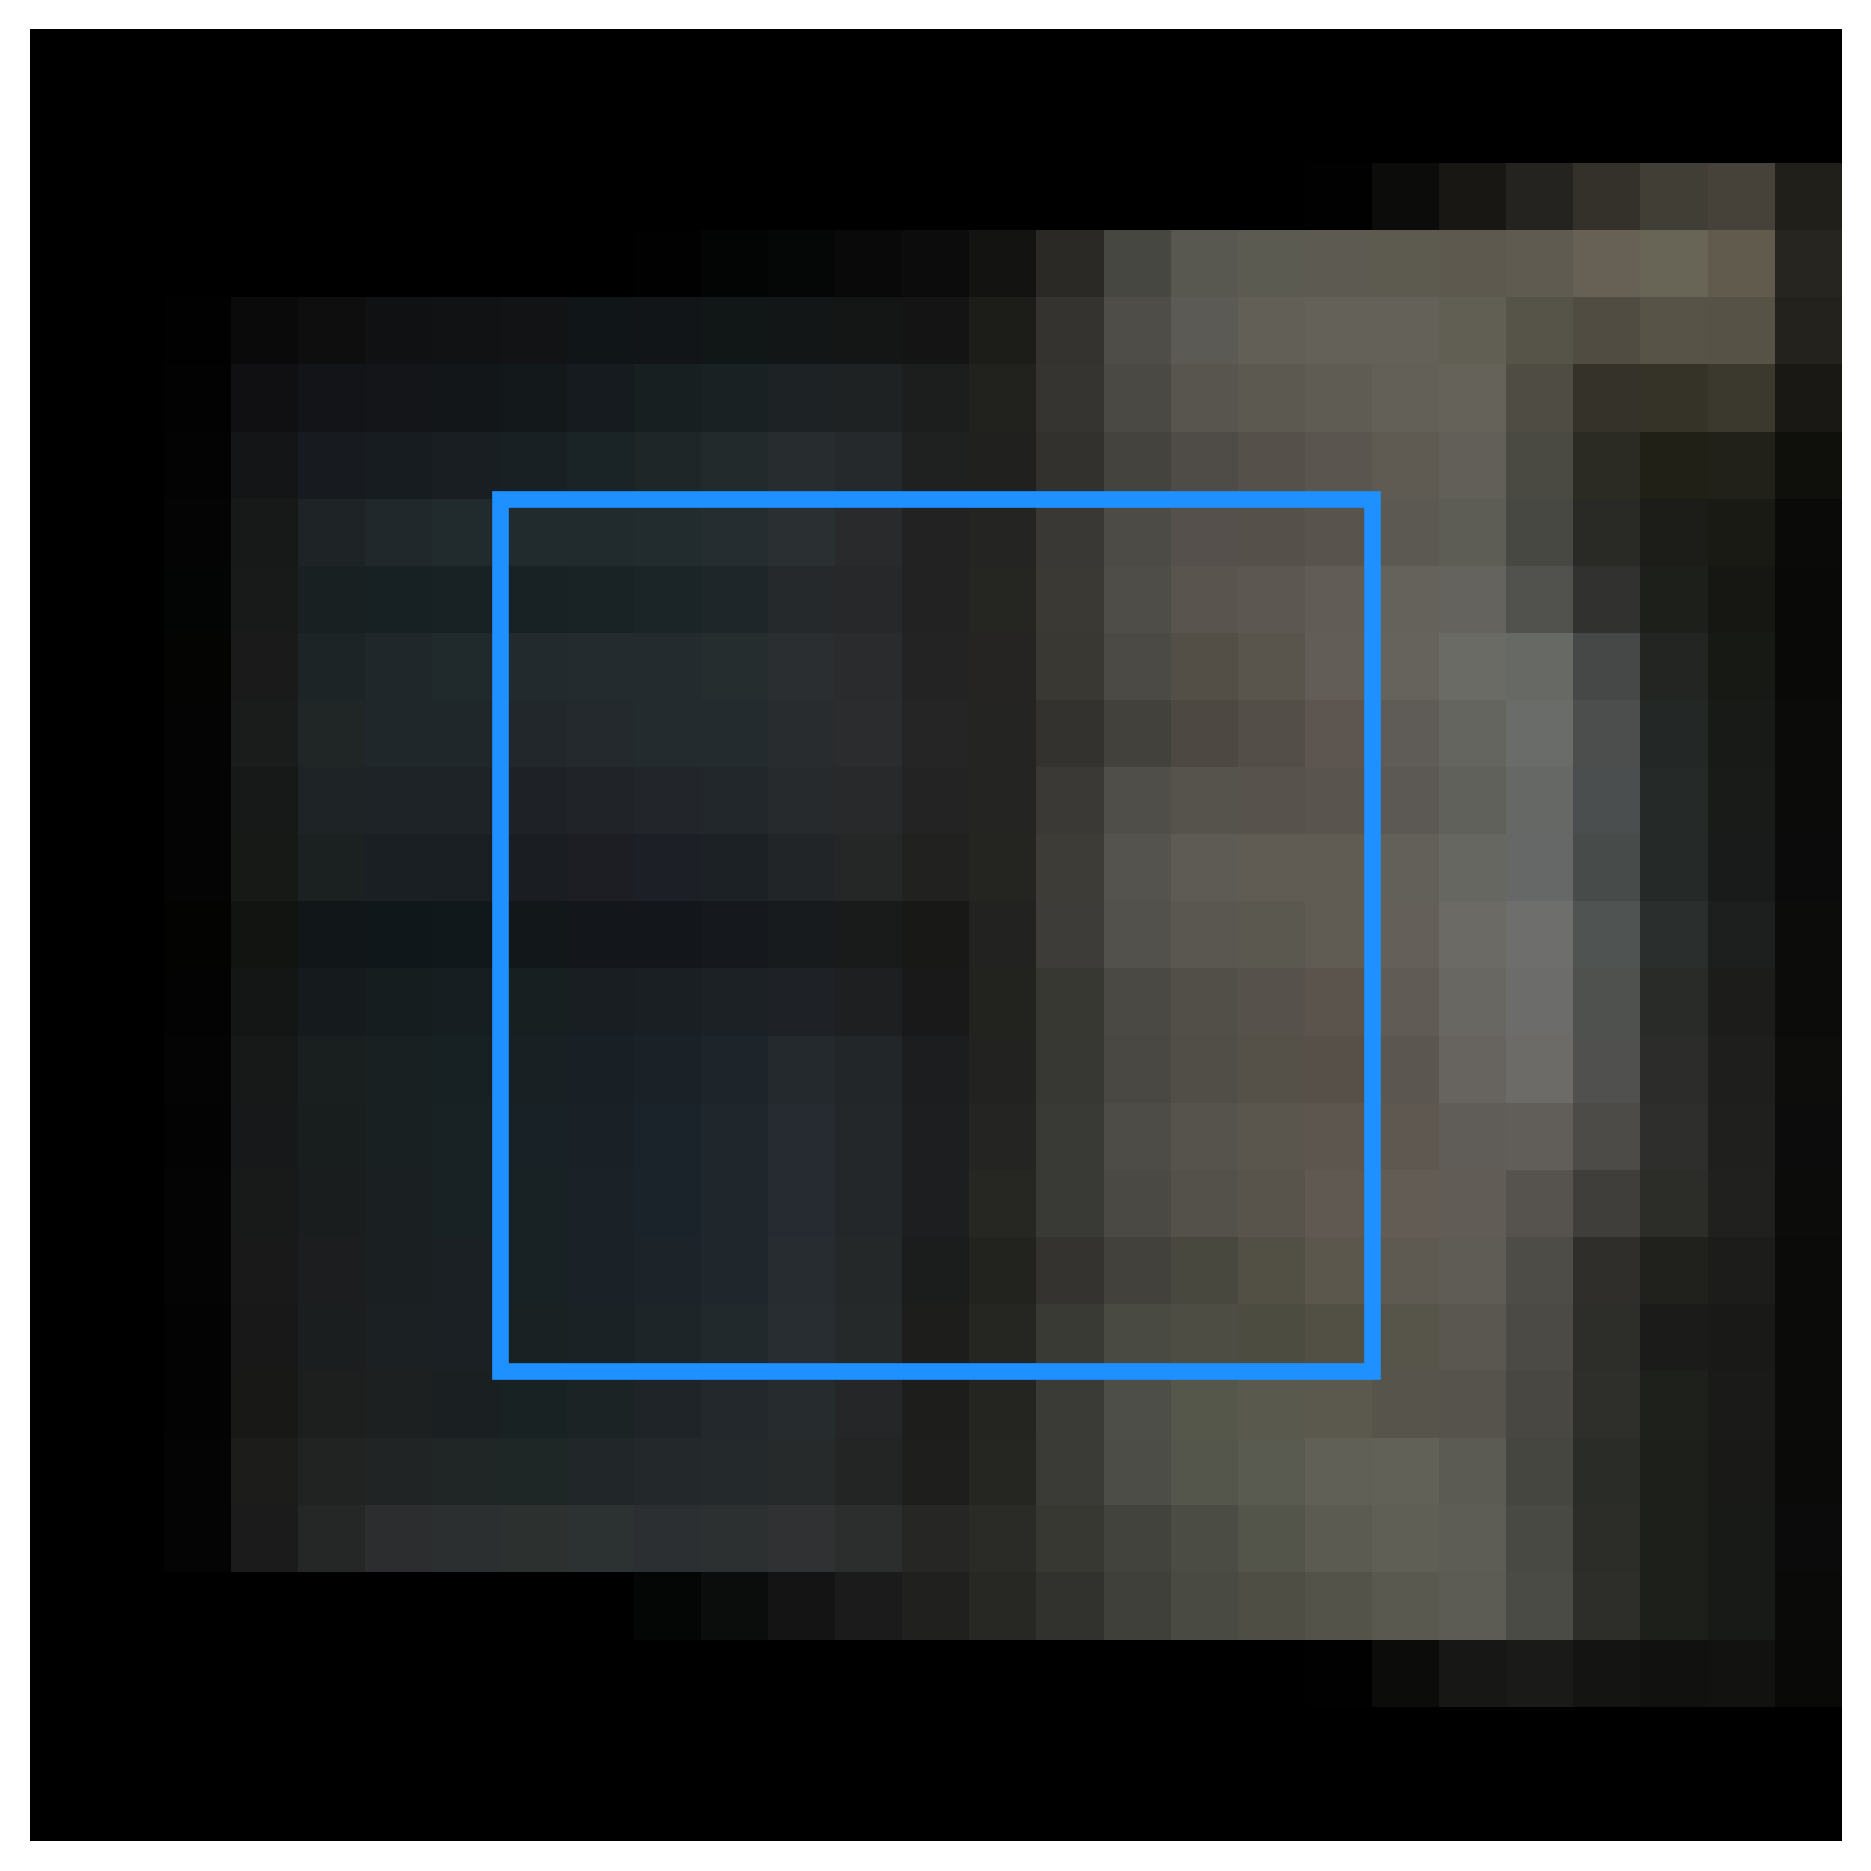

In [64]:
fig, axis = plt.subplots(1, 1, figsize=(8, 8), dpi=300)

kp_idx = 184
h_idx = 2

w_vis_patch_painter.draw_warp_visualization_patch(axis, 0, kp_idx, h_idx)

draw_patch_border(axis, 
                  synth_h_dist.patch_scaled_size // 2, 
                  patch_detector.patch_size, ec='dodgerblue', lw=4)


### Visualize keypoint projections

In [65]:
keypoint_patch_painter = KeypointPatchPainter(batch['image'], kp_samples.kp)
kp_proj_painter = KeypointProjectionPainter(kp_proj)

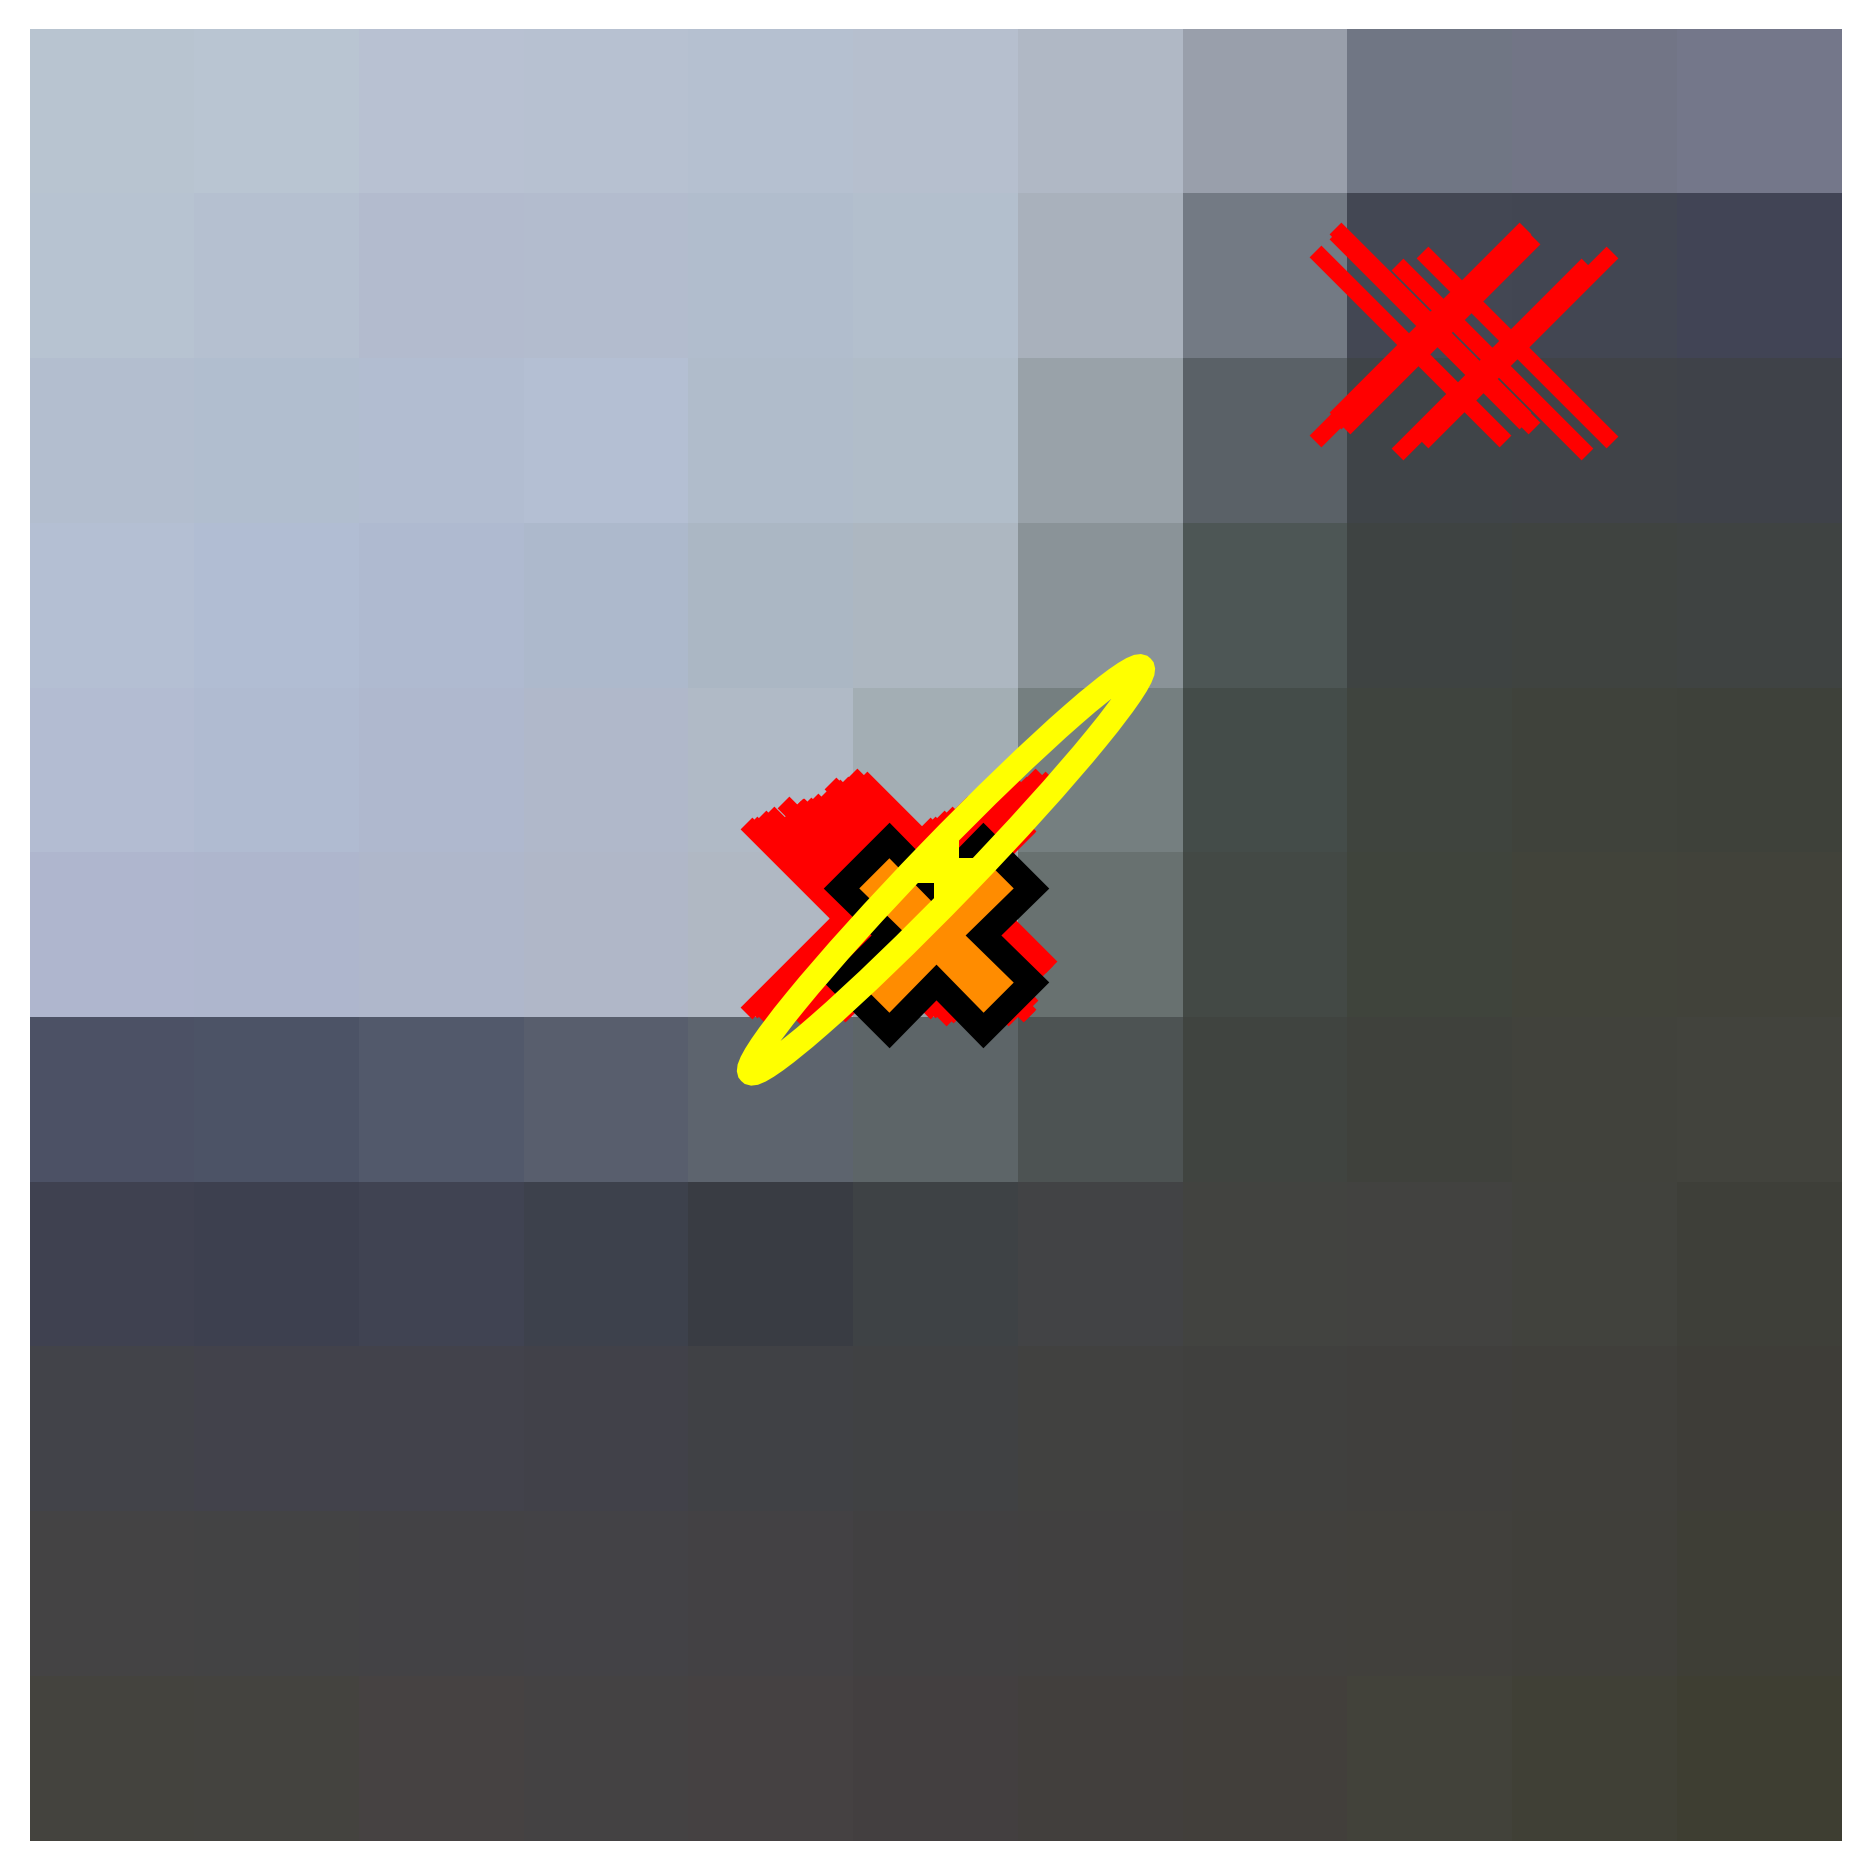

In [133]:
fig, axis = plt.subplots(1, 1, figsize=(8, 8), dpi=300)

kp_idx = 335

patch_size = 11
patch_h_size = patch_size // 2

keypoint_patch_painter.draw_keypoint_patch(axis, 0, kp_idx, patch_size)

kp_proj_painter.draw_keypoint_projections(axis, 0, kp_idx, patch_h_size, markersize=45.5, markeredgewidth=4.0)

draw_keypoint(axis, 5, markersize=45.5, markeredgewidth=6.0)

kp_proj_painter.draw_unimodal_approximation_mean(axis, 0, kp_idx, patch_h_size, markersize=15.5, markeredgewidth=6)
kp_proj_painter.draw_unimodal_approximation_covariance(axis, 0, kp_idx, patch_h_size, linewidth=6)

## Calculate synthetic $\beta$-EME 

In [41]:
beta_eme = BetaEME(cfg.train.criterion.beta_eme.bound,
                   cfg.train.criterion.beta_eme.use_decomposition)

kp_synth_beta_eme = beta_eme.calculate(kp_proj)
kp_synth_beta_eme = beta_eme.replace_with_max_value(kp_synth_beta_eme, kp_samples.cand_kp_noise_mask, patch_detector, synth_h_dist.beta)

# Calculate loss function

In [42]:
from source.train_task import kp_mask_loss

loss = (kp_samples.kp_neur_beta_eme - kp_synth_beta_eme) ** 2

kp_mask_loss(loss, kp_samples.cand_kp_mask)

tensor(1.5927, grad_fn=<DivBackward0>)